I will try to utilize the Scikit-learn library to identify the components of the Milky Way thorugh observed and modeled data of evolved stars.

The data comes from both the GAIA database and a set of models generated through the Bayesian Stellar algorithm (BASTA).

Since the data used was put together more than a year ago, I no longer have the scripts I used to query/clean/compute it, but I have managed to salvage Stellar_data.csv, what contains more than enough data just to look at what SKlearn has to say about it.

This is not the place to introduce and explain the physics/theory behind the original research, but the point is that the MW can be dissected into 3 (4) components in which the stars have different parameters (Mainly metallicity and velocities) tend to have different distribution among the components and the components also tend to occupy different areas with different density. 


In [179]:
#Import the libraries
import pandas as pd # good ol' pandas
import matplotlib.pyplot as plt # plt - I have heard a few times that seaborn is probably better but I feel mor comfortable using Plt.
import numpy as np # I could import only parts of this, but numpy is not a huge library - and I don't want to return here every time to import something new

#A simple clustering using K means 
from sklearn.cluster import KMeans # I will try this at first
from sklearn.cluster import MiniBatchKMeans # MBKmeans is a faster method of doing this using randomised sample "batches". I suspect it will have lower quality, but would like to see exactly how much lower it is.
#  Spectral clustering is one of the most popular algorithms for clustering, in most cases capable of outperforming K-means. I'll give it a shot.
from sklearn.cluster import SpectralClustering
#I chose these since I clearly do know the number of clusters (which is 3, or arguably 2, if the halo has too few representatives), which makes this method to be the best

In [180]:
# Load the data
raw_data=pd.read_csv("Stellar_data.dat")
raw_data.head()# Just check that everything s alright


,Unnamed: 0,#KIC_ID,U,V,W,TMASS_ID,J_APOGEE,ERROR_J_APOGEE,H_APOGEE,ERROR_H_APOGEE,...,age_errm,massfin,massfin_errp,massfin_errm,radPhot,radPhot_errp,radPhot_errm,X_corr,Y_corr,Z_corr
0,0,8004686,6.446590,-0.437957,8.896258,18402676+4351412,10.278,0.027,9.661,0.032,...,1700.0,1.270484,0.111151,0.099941,13.230761,0.406343,0.376552,-7744.699246,1819.240387,721.989447
1,1,7935931,9.507005,-51.649046,-29.677726,18403944+4345281,10.198,0.026,9.624,0.032,...,3200.0,1.046948,0.086881,0.071424,10.485417,0.246277,0.251792,-7858.195429,1446.533202,576.310870
2,2,7798033,NaN,NaN,NaN,18404744+4335540,12.460,0.036,11.982,0.035,...,1000.0,1.286916,0.142384,0.175736,10.411795,0.426223,0.327750,-6780.735283,4842.950665,1877.174682
3,3,8004863,66.765419,36.775263,-10.051212,18405556+4353012,11.207,0.026,10.655,0.032,...,1100.0,1.217457,0.089424,0.066724,7.706545,0.229303,0.226802,-7769.247193,1745.980625,690.813248
4,4,7936033,-42.361840,-41.484976,-3.757361,18405585+4347083,9.727,0.024,9.084,0.030,...,3600.0,0.945338,0.073796,0.050567,16.643899,0.409876,0.398724,-7785.051135,1684.822775,666.516918


Well, in the data we have a huge bunch of parameters that are either not important or can't really be quantified (IDs - those are unimportant as well).

I'm about to cheat a little bit, since I know which parameters should actually matter, I'll just explore those a little bit without much thought on other parameters - which could  in theory matter as well.

Text(0, 0.5, '# of stars')

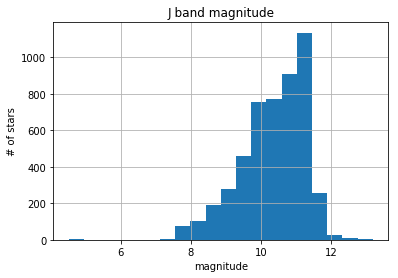

In [37]:
#Just showing a few distributions in the following few cells
raw_data.hist("J_APOGEE", bins=20)
plt.title("J band magnitude")
plt.xlabel("magnitude")
plt.ylabel("# of stars")


In [75]:
raw_data.keys()

Index(['Unnamed: 0', '#KIC_ID', 'U', 'V', 'W', 'TMASS_ID', 'J_APOGEE',
       'ERROR_J_APOGEE', 'H_APOGEE', 'ERROR_H_APOGEE', 'K_APOGEE',
       'ERROR_K_APOGEE', 'RA_GAIA', 'DEC_GAIA', 'TEFF_APOGEE',
       'ERROR_TEFF_APOGEE', 'M_H_BASTA', 'ERROR_M_H_APOGEE', 'LOGG_APOGEE',
       'ERROR_LOGG_APOGEE', 'PARALLAX_GAIA', 'ERROR_PARALLAX_GAIA_x',
       'EVO_BASTA', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'ERROR_PARALLAX_GAIA_y', 'radial_velocity', 'radial_velocity_error',
       'FeH', 'age', 'age_errp', 'age_errm', 'massfin', 'massfin_errp',
       'massfin_errm', 'radPhot', 'radPhot_errp', 'radPhot_errm', 'X_corr',
       'Y_corr', 'Z_corr'],
      dtype='object')

This is the magnitude (the J-band magnitude, between 1.1 and 1.5 micrometers) - It shouldn't affect the clustering directly, but nice to look at in case there is any selection bias present. 

In this instance I don't think there would be any, this is the tendency one would expect.

# Distributions

Now I'll briefly explore the parameter space to show how the parameters vary depending on the components.

## Metallicity

Text(0, 0.5, '# of stars')

<Figure size 432x288 with 0 Axes>

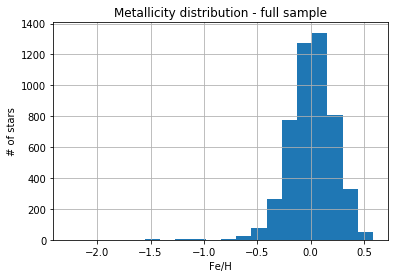

<Figure size 432x288 with 0 Axes>

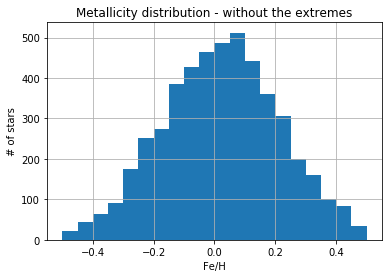

In [38]:
plt.figure()
raw_data.hist("M_H_BASTA", bins=20)
plt.title("Metallicity distribution - full sample")
plt.xlabel("Fe/H")
plt.ylabel("# of stars")


plt.figure()
raw_data.hist("M_H_BASTA", bins=20, range=[-.5,.5])
plt.title("Metallicity distribution - without the extremes")
plt.xlabel("Fe/H")
plt.ylabel("# of stars")

From this alone it is not immediately clear that we are facing two separate clusters (a significant portion of the halo - the third component - is already excluded - with the extreme metalpoor end shown in the first figure), but it will be apparent. 


# Toomre diagram

A Toomre diagram shows __V__ vs. $\sqrt{U^2 + W^2}$ for the stars -  U Is the velocity towards the galactic center, V is the velocity in the direction of galactic rotation, and W is the velocity perpendicular to the galactic plane - in the direction of the North Galactic Pole.

The Toomre diagram is used to show the "temperature" (In a kinematic sense, not the actual surface temperature) of the stars.

In theory the separation "should be" around $v_{thin\_disk}<100 \frac{km}{s}$ and $200  \frac{km}{s} > v_{thick\_disk}>100  \frac{km}{s}$, but I find the inner separation to be more believable at somewhere around $80  \frac{km}{s}$, not that it matters for now - for one, it is not supposed to be a "hard" limit, and also... SKlearn will decide for itself.

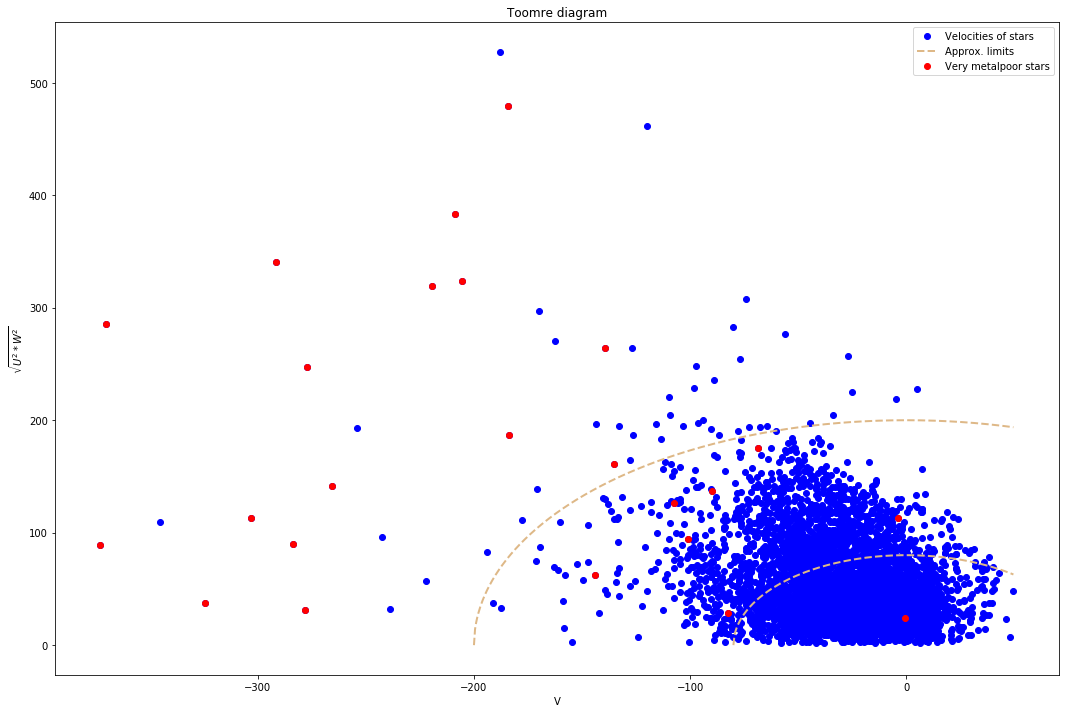

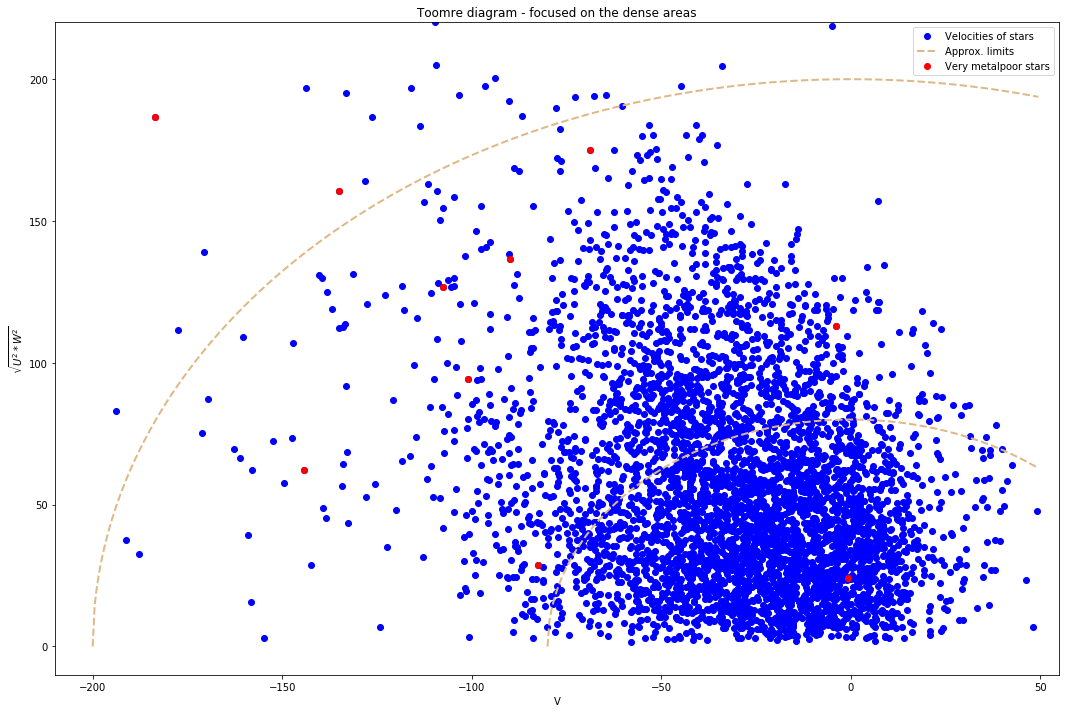

In [51]:
#for the Toomre:
t1=raw_data["V"]
t2=np.sqrt(raw_data["U"]*raw_data["U"]+raw_data["W"]*raw_data["W"])
#Just define the borders for visualization
xcirc=np.arange(-80,50,.5)
xcirc2=np.arange(-200,50,.5)
ycirc=np.sqrt(80*80*np.ones(len(xcirc))-xcirc*xcirc)
ycirc2=np.sqrt(200*200*np.ones(len(xcirc2))-xcirc2*xcirc2)

plt.figure(figsize=(18,12))
plt.title("Toomre diagram")
plt.xlabel("V")
plt.ylabel("$\\sqrt{U^2 * W^2}$")
plt.plot(t1, t2, "bo", label="Velocities of stars")
plt.plot(xcirc, ycirc, c="burlywood", ls=("dashed"), lw=2, label="Approx. limits")
plt.plot(xcirc2, ycirc2, c="burlywood", ls=("dashed"), lw=2, label="__nolegend__")
plt.plot(raw_data[raw_data["M_H_BASTA"]< -.7]["V"], np.sqrt(raw_data[raw_data["M_H_BASTA"]< -.7]["W"]*raw_data[raw_data["M_H_BASTA"]< -.7]["W"]+raw_data[raw_data["M_H_BASTA"]< -.7]["U"]*raw_data[raw_data["M_H_BASTA"]< -.7]["U"]), "ro", label="Very metalpoor stars")
plt.legend()

plt.figure(figsize=(18,12))
plt.title("Toomre diagram - focused on the dense areas")
plt.xlabel("V")
plt.ylabel("$\\sqrt{U^2 * W^2}$")
plt.plot(t1, t2, "bo", label="Velocities of stars")
plt.plot(xcirc, ycirc, c="burlywood", ls=("dashed"), lw=2, label="Approx. limits")
plt.plot(xcirc2, ycirc2, c="burlywood", ls=("dashed"), lw=2, label="__nolegend__")
plt.plot(raw_data[raw_data["M_H_BASTA"]< -.7]["V"], np.sqrt(raw_data[raw_data["M_H_BASTA"]< -.7]["W"]*raw_data[raw_data["M_H_BASTA"]< -.7]["W"]+raw_data[raw_data["M_H_BASTA"]< -.7]["U"]*raw_data[raw_data["M_H_BASTA"]< -.7]["U"]), "ro", label="Very metalpoor stars")
plt.xlim(-210,55)
plt.ylim(-10,220)
plt.legend()

It can be noticed (and upon further investigation it becomes even clearer) that the very metalpoor stars are much more prominent in the halo - this makes sense, since the halo has historically contained less stars - thus, lower stellar yields.

This tendency stays for the thin and thick disk as well: the thin disk tends to have "richer" stars than the thick disk.

Below I show the metalicity distribution of the stars with total velocity above and beyond $80  \frac{km}{s}$.

In the following plots I call this first approximation (with division based on the velocities) the thick and thin disks, even though the distinction is much more complicated and is based on many more variables, such as metallicity, Z coordinate...

Text(0, 0.5, '# of stars')

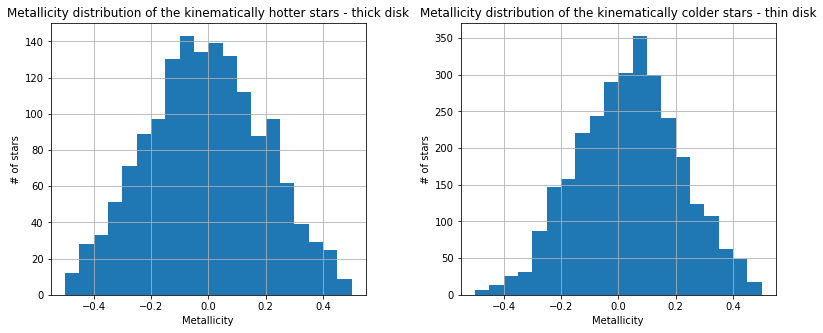

In [71]:
plt.subplots(1,2, figsize=(13,5))

ax=plt.subplot(1,2,1)
raw_data[(80*80<t1**2+t2**2) & (200*200>t1**2+t2**2)].hist("M_H_BASTA", ax=ax,range=[-.5,.5], bins=20)#Range adjusted to exclude the extremes
ax.set_title("Metallicity distribution of the kinematically hotter stars - thick disk")
ax.set_xlabel("Metallicity")
ax.set_ylabel("# of stars")


ax2=plt.subplot(1,2,2)
raw_data[(80*80>t1**2+t2**2)].hist("M_H_BASTA", ax=ax2,range=[-.5,.5], bins=20)#Range adjusted to exclude the extremes
ax2.set_title("Metallicity distribution of the kinematically colder stars - thin disk")
ax2.set_xlabel("Metallicity")
ax2.set_ylabel("# of stars")

It is clear that in the thin disk has higher metallicity - on average slightly higher than solar, while the thick with this very basic approximation still seems to have uncertainties regarding the "top" of the distribution, but slightly lower average metallicity.

There are other parameters and correlations that could be - and have been in the original project - explored, but I think this should give a general idea of the three components and their main parameters, so... let's jump into the clustering.
   

# Creating an input

The data currently has waay more variables than it should, so at first I create a new dataframe that fits the whole thing better. 

In order to do this, I would have to choose the variables that could matter for the clustering.

These would be the following:

- Metallicity 
- Total velocity ($v_{tot} =\sqrt{U^2 + W^2 + V^2} $)
- Z - Distance from the plane of the MW. The thin disk should be confined to the plane the most, while the halo should not be confined at all. 


In [181]:
Input_values=pd.DataFrame()
Input_values["Metal"]=raw_data["M_H_BASTA"]
Input_values["Vel"]=np.sqrt(raw_data["U"]*raw_data["U"]+raw_data["V"]*raw_data["V"]+raw_data["W"]*raw_data["W"])
Input_values["Z"]=raw_data["Z_corr"]
Input_values.head()
print(Input_values.isnull().sum()) # it seems in 375 cases I did not have accurate measurements for the velocity, time to remove those cases
Input_values=Input_values[~np.isnan(Input_values["Vel"])] # Fixed. Also removed the ones where Z was not defined.


Metal      0
Vel      375
Z         16
dtype: int64


As a next step (though I wouldn't call either of these a full step) I try to normalize the values since... well, the algorithm likes to handle "nice" numbers...

Metallicity seems to be pretty good, since the overwhelming majority of the values are alread between -1 and 1, I don't plan to touch this.

For Z the mean and the median are 409 and 460, so a division by 450 seems reasonable. This way 99%+ of the values will be under 3. The few outliers (only 6 instances with Z>2000)

The velocities are confined between 0 and 550, with the mean and median are around 70. I chose this value to norm this, this way the overwhelming majority (<200) will be under 3 as well. The few outliers give the halo anyway... 

Means: 
Metal      0.010066
Vel       72.276119
Z        460.290970
dtype: float64
Medians: 
Metal      0.020940
Vel       63.157266
Z        409.448663
dtype: float64
Min: 
Metal    -2.267785
Vel       3.385486
Z        58.523518
dtype: float64
Max: 
Metal       0.586369
Vel       559.848666
Z        4921.708807
dtype: float64


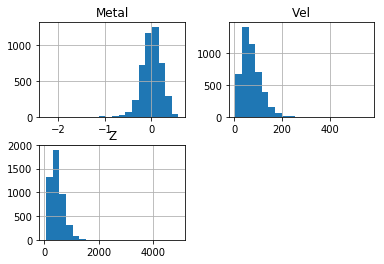

In [182]:
Input_values.hist(bins=20)
print("Means: \n" + str(Input_values.mean()))
print("Medians: \n"+ str(Input_values.median()))
print("Min: \n"+ str(Input_values.min()))
print("Max: \n"+ str(Input_values.max()))

In [183]:
Input_values["Z"]=Input_values["Z"]/450
Input_values["Vel"]=Input_values["Vel"]/70

Time to feed this thing into the first algorithm.

In [184]:
Input_values=Input_values.to_numpy()


In [185]:
Input_values.shape

(4595, 3)

In [119]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(Input_values)

In [145]:
results_kmeans=kmeans.labels_
# Let's just kick out the "wrong" values from the original data as well.
raw_data=raw_data[~np.isnan(raw_data.U)]
raw_data=raw_data.reset_index(drop=True)
raw_data["kmeans_class"]=results_kmeans

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1FD0BC50>]],
      dtype=object)

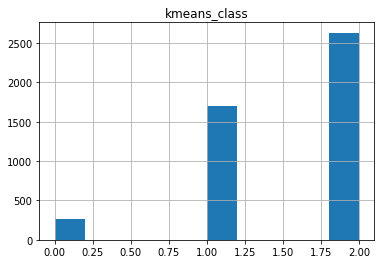

In [147]:
raw_data.hist("kmeans_class")

In [148]:
t1c1=raw_data[raw_data["kmeans_class"]==1]["V"]
t2c1=np.sqrt(raw_data[raw_data["kmeans_class"]==1]["U"]*raw_data[raw_data["kmeans_class"]==1]["U"]+raw_data[raw_data["kmeans_class"]==1]["W"]*raw_data[raw_data["kmeans_class"]==1]["W"])
t1c2=raw_data[raw_data["kmeans_class"]==2]["V"]
t2c2=np.sqrt(raw_data[raw_data["kmeans_class"]==2]["U"]*raw_data[raw_data["kmeans_class"]==2]["U"]+raw_data[raw_data["kmeans_class"]==2]["W"]*raw_data[raw_data["kmeans_class"]==2]["W"])

t1c0=raw_data[raw_data["kmeans_class"]==0]["V"]
t2c0=np.sqrt(raw_data[raw_data["kmeans_class"]==0]["U"]*raw_data[raw_data["kmeans_class"]==0]["U"]+raw_data[raw_data["kmeans_class"]==0]["W"]*raw_data[raw_data["kmeans_class"]==0]["W"])





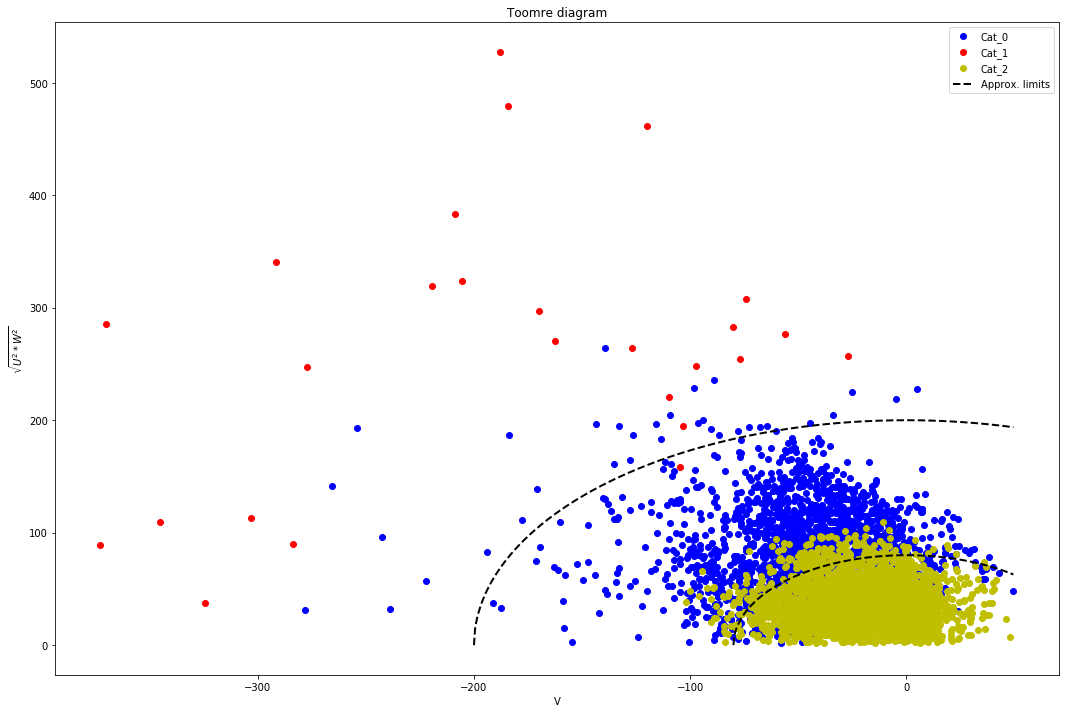

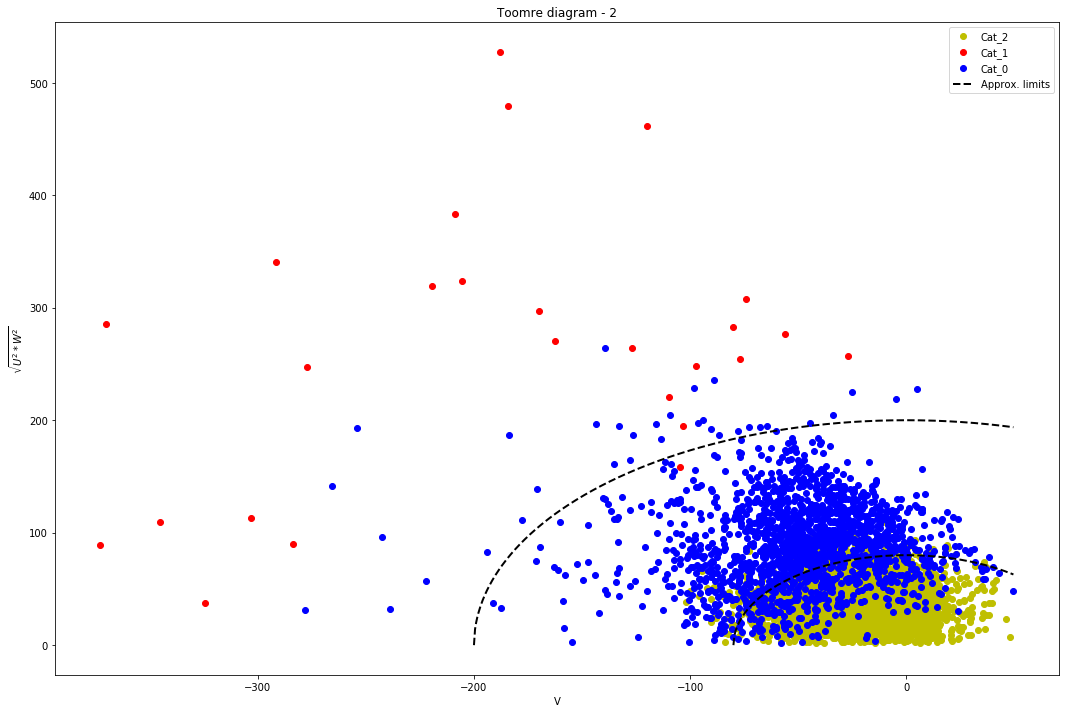

In [188]:

plt.figure(figsize=(18,12))
plt.title("Toomre diagram")
plt.xlabel("V")
plt.ylabel("$\\sqrt{U^2 * W^2}$")
plt.plot(t1c0, t2c0, "bo", label="Cat_0")
plt.plot(t1c1, t2c1, "ro", label="Cat_1")
plt.plot(t1c2, t2c2, "yo", label="Cat_2")
plt.plot(xcirc, ycirc, c="k", ls=("dashed"), lw=2, label="Approx. limits")
plt.plot(xcirc2, ycirc2, c="k", ls=("dashed"), lw=2, label="__nolegend__")
#plt.plot(raw_data[raw_data["M_H_BASTA"]< -.7]["V"], np.sqrt(raw_data[raw_data["M_H_BASTA"]< -.7]["W"]*raw_data[raw_data["M_H_BASTA"]< -.7]["W"]+raw_data[raw_data["M_H_BASTA"]< -.7]["U"]*raw_data[raw_data["M_H_BASTA"]< -.7]["U"]), "ro", label="Very metalpoor stars")
plt.legend()


plt.figure(figsize=(18,12))
plt.title("Toomre diagram - 2")
plt.xlabel("V")
plt.ylabel("$\\sqrt{U^2 * W^2}$")
plt.plot(t1c2, t2c2, "yo", label="Cat_2")
plt.plot(t1c1, t2c1, "ro", label="Cat_1")
plt.plot(t1c0, t2c0, "bo", label="Cat_0")
plt.plot(xcirc, ycirc, c="k", ls=("dashed"), lw=2, label="Approx. limits")
plt.plot(xcirc2, ycirc2, c="k", ls=("dashed"), lw=2, label="__nolegend__")
#plt.plot(raw_data[raw_data["M_H_BASTA"]< -.7]["V"], np.sqrt(raw_data[raw_data["M_H_BASTA"]< -.7]["W"]*raw_data[raw_data["M_H_BASTA"]< -.7]["W"]+raw_data[raw_data["M_H_BASTA"]< -.7]["U"]*raw_data[raw_data["M_H_BASTA"]< -.7]["U"]), "ro", label="Very metalpoor stars")
plt.legend()

This is pretty consistent with what we consider to be the case - the halo is much more prominent than I would expect (about 4 times more stars are included in the halo by the algorithm than by me), but I can accept it in a way, that it tried to "force" three meaningful components since I can input the amount of classes.

Checking on the stats:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2383CF10>]],
      dtype=object)

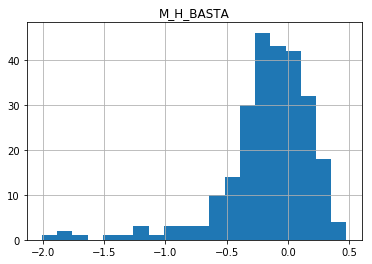

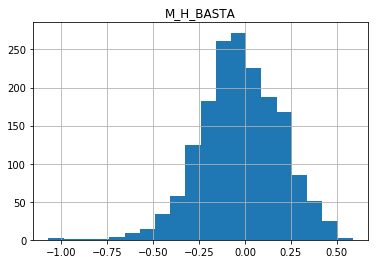

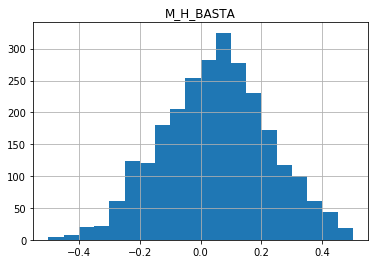

In [160]:
raw_data[raw_data["kmeans_class"]==0].hist("M_H_BASTA", bins=20)
raw_data[raw_data["kmeans_class"]==1].hist("M_H_BASTA", bins=20)
raw_data[raw_data["kmeans_class"]==2].hist("M_H_BASTA", range=[-.5,.5], bins=20)

This also seems to reproduce what the theory gives to us.

Next up, let's check how the mini-batch K-mean fares.


In [169]:
mbkmeans = MiniBatchKMeans(n_clusters=3, random_state=42,batch_size=500).fit(Input_values) # The problem here is that with smaller batch sizes I ran into the problem caused by the uneven size of the batches - namely, the algorithm 'forced' way too many stars to be in the halo. Much higher values than this would defeat the purpose of batches

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x24D66230>]],
      dtype=object)

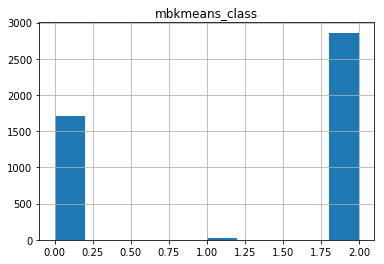

In [170]:
results_mbkmeans=mbkmeans.labels_
# Let's just kick out the "wrong" values from the original data as well.

raw_data["mbkmeans_class"]=results_mbkmeans
raw_data.hist("mbkmeans_class")

This seems to be slightly different from the previous, let's look at the toomre diagram 

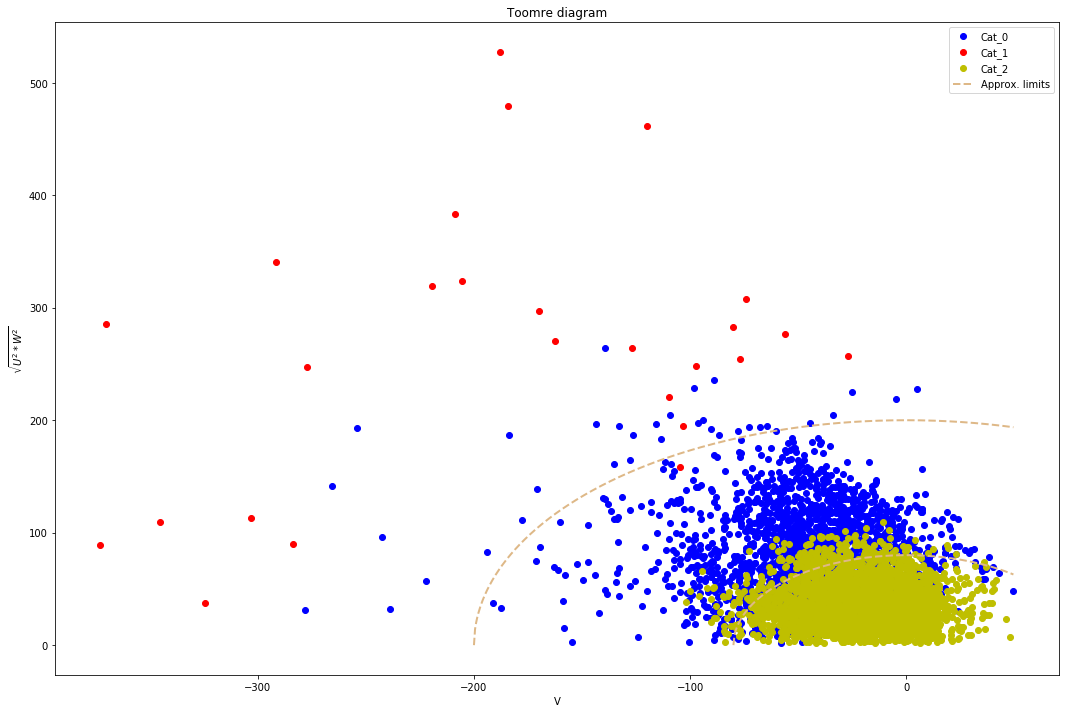

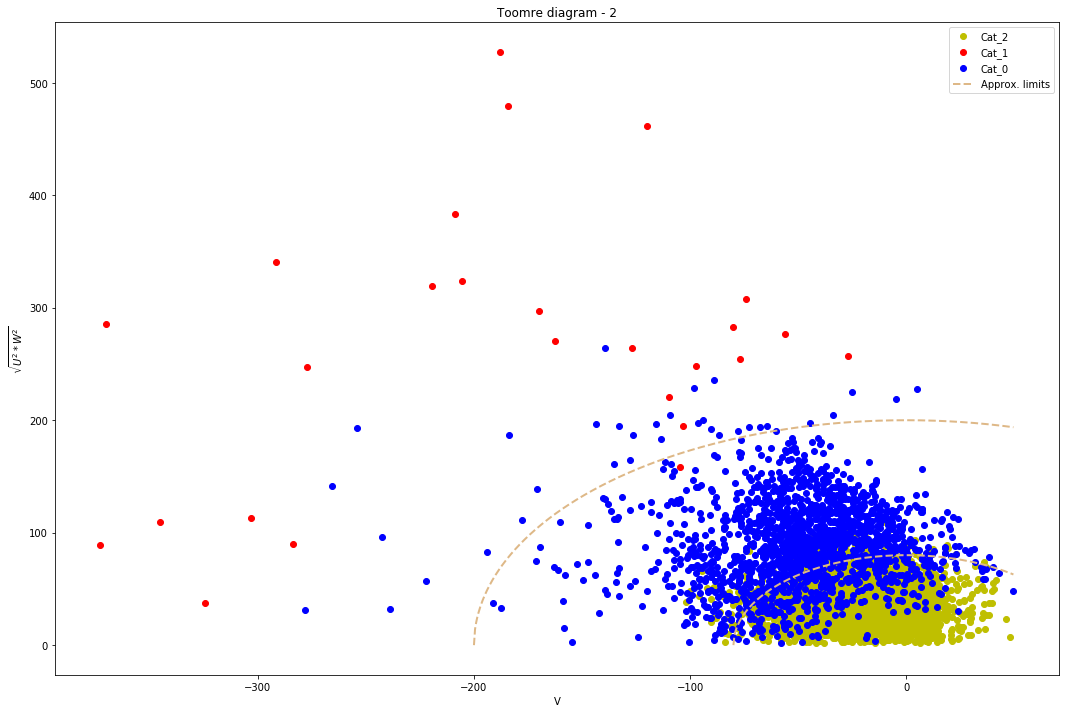

In [171]:
t1c1=raw_data[raw_data["mbkmeans_class"]==1]["V"]
t2c1=np.sqrt(raw_data[raw_data["mbkmeans_class"]==1]["U"]*raw_data[raw_data["mbkmeans_class"]==1]["U"]+raw_data[raw_data["mbkmeans_class"]==1]["W"]*raw_data[raw_data["mbkmeans_class"]==1]["W"])
t1c2=raw_data[raw_data["mbkmeans_class"]==2]["V"]
t2c2=np.sqrt(raw_data[raw_data["mbkmeans_class"]==2]["U"]*raw_data[raw_data["mbkmeans_class"]==2]["U"]+raw_data[raw_data["mbkmeans_class"]==2]["W"]*raw_data[raw_data["mbkmeans_class"]==2]["W"])

t1c0=raw_data[raw_data["mbkmeans_class"]==0]["V"]
t2c0=np.sqrt(raw_data[raw_data["mbkmeans_class"]==0]["U"]*raw_data[raw_data["mbkmeans_class"]==0]["U"]+raw_data[raw_data["mbkmeans_class"]==0]["W"]*raw_data[raw_data["mbkmeans_class"]==0]["W"])







plt.figure(figsize=(18,12))
plt.title("Toomre diagram")
plt.xlabel("V")
plt.ylabel("$\\sqrt{U^2 * W^2}$")
plt.plot(t1c0, t2c0, "bo", label="Cat_0")
plt.plot(t1c1, t2c1, "ro", label="Cat_1")
plt.plot(t1c2, t2c2, "yo", label="Cat_2")
plt.plot(xcirc, ycirc, c="k", ls=("dashed"), lw=2, label="Approx. limits")
plt.plot(xcirc2, ycirc2, c="k", ls=("dashed"), lw=2, label="__nolegend__")
#plt.plot(raw_data[raw_data["M_H_BASTA"]< -.7]["V"], np.sqrt(raw_data[raw_data["M_H_BASTA"]< -.7]["W"]*raw_data[raw_data["M_H_BASTA"]< -.7]["W"]+raw_data[raw_data["M_H_BASTA"]< -.7]["U"]*raw_data[raw_data["M_H_BASTA"]< -.7]["U"]), "ro", label="Very metalpoor stars")
plt.legend()


plt.figure(figsize=(18,12))
plt.title("Toomre diagram - 2")
plt.xlabel("V")
plt.ylabel("$\\sqrt{U^2 * W^2}$")
plt.plot(t1c2, t2c2, "yo", label="Cat_2")
plt.plot(t1c1, t2c1, "ro", label="Cat_1")
plt.plot(t1c0, t2c0, "bo", label="Cat_0")
plt.plot(xcirc, ycirc, c="k", ls=("dashed"), lw=2, label="Approx. limits")
plt.plot(xcirc2, ycirc2, c="k", ls=("dashed"), lw=2, label="__nolegend__")
#plt.plot(raw_data[raw_data["M_H_BASTA"]< -.7]["V"], np.sqrt(raw_data[raw_data["M_H_BASTA"]< -.7]["W"]*raw_data[raw_data["M_H_BASTA"]< -.7]["W"]+raw_data[raw_data["M_H_BASTA"]< -.7]["U"]*raw_data[raw_data["M_H_BASTA"]< -.7]["U"]), "ro", label="Very metalpoor stars")
plt.legend()

Honestly, this batch value gives a more accurate halo - according to what I would expect - which is a bit peculiar. It doesn't include the super-metalpoor stars in the halo though. This is not necessarily the problem, but it would be an interesting anomaly

One could argue that this halo is underrepresented, and the thick disk is "too thick", but the opposite could be said about the standard k-means algorithm. It is also probable that the change of random states could result in slightly different results.

Just a quick glance at the statistics:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x227B29F0>]],
      dtype=object)

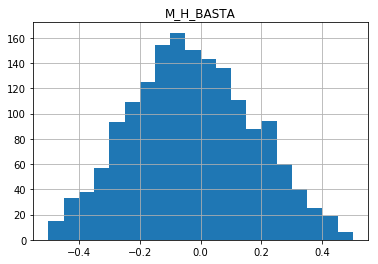

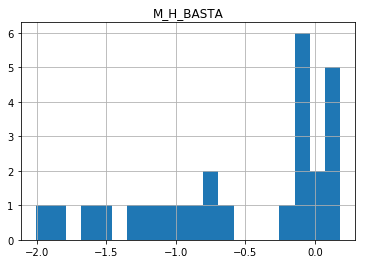

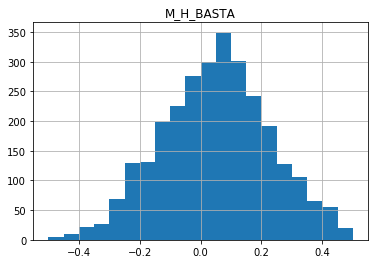

In [174]:
raw_data[raw_data["mbkmeans_class"]==0].hist("M_H_BASTA", bins=20, range=[-.5,.5])
raw_data[raw_data["mbkmeans_class"]==1].hist("M_H_BASTA", bins=20)
raw_data[raw_data["mbkmeans_class"]==2].hist("M_H_BASTA",  bins=20, range=[-.5,.5])

To be honest, I would pick this model any day over the other, provided that I'm allowed to "manually change" the categories of the few outliers (The very metal-poor stars should belong to the halo in my opinion - probably this is due to the fact that the halo could also be split into 2.)

Lastly, let's try Spectral clustering and see what I can get out of it

In [187]:
spectral = SpectralClustering(n_clusters=3).fit(Input_values) 

MemoryError: 

So... The thing is, spectral clustering couldn't be performed on my current computer. After thransfering the whole thing to Kaggle, I have managed to run it with multiple parameters, but I could not achieve a parameter set where three clusters were identified (In all cases cat. 1,2 would consist of less than 10 stars.) - It seems that this method puts too big of an emphasis on Z - which is the most volatile parameter with really heavy outliers. Upon removing this parameter from the fitting, this method still prioritizes "splitting the halo" into two components instead of the disk. 

This should not come as a huge surpirse, since - from the documentation - "In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. For instance when clusters are nested circles on the 2D plane.". 

I'm sure there is a way for the spectral clustering to find a parameter set that suits this task, but it is better to settle with the two variants of K-means clustering which have proven more successful.

I could continue adding more parameters to see how the models evolve since there surely are more differences between the components, but I think this is more than sufficient description of the components. 

I could look at other distributions of the components as well, but the Toomre and metal abundance are the most important. And the goal - trying SKlearn on a large and unique dataset - have been achieved.